<ipython-input-1-3cfdd405b24e>:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


Processing file: results-Bullfrog/bullfrog_birdnetv2.4_t0_e50_b32_l0.001.txt
Processing file: results-Bullfrog/bullfrog_birdnetv2.4_t25_e50_b32_l0.001.txt
Processing file: results-Bullfrog/bullfrog_birdnetv2.4_t50_e50_b32_l0.001.txt
Processing file: results-Bullfrog/bullfrog_birdnetv2.4_t75_e50_b32_l0.001.txt
Processing file: results-Bullfrog/bullfrog_birdnetv2.4_t100_e50_b32_l0.001.txt
Processing file: results-Bullfrog/bullfrog_birdnetv2.4_t125_e50_b32_l0.001.txt
Processing file: results-Bullfrog/bullfrog_birdnetv2.4_t150_e50_b32_l0.001.txt
Processing file: results-Bullfrog/bullfrog_birdnetv2.4_t175_e50_b32_l0.001.txt
Processing file: results-Bullfrog/bullfrog_birdnetv2.4_t200_e50_b32_l0.001.txt
Saved merged table to 'output/bullfrog_merged_table.csv'
Saved metrics summary to 'output/bullfrog_metrics_summary.csv'
ROC-AUC plot saved to output/bullfrog_roc_auc_plot.png


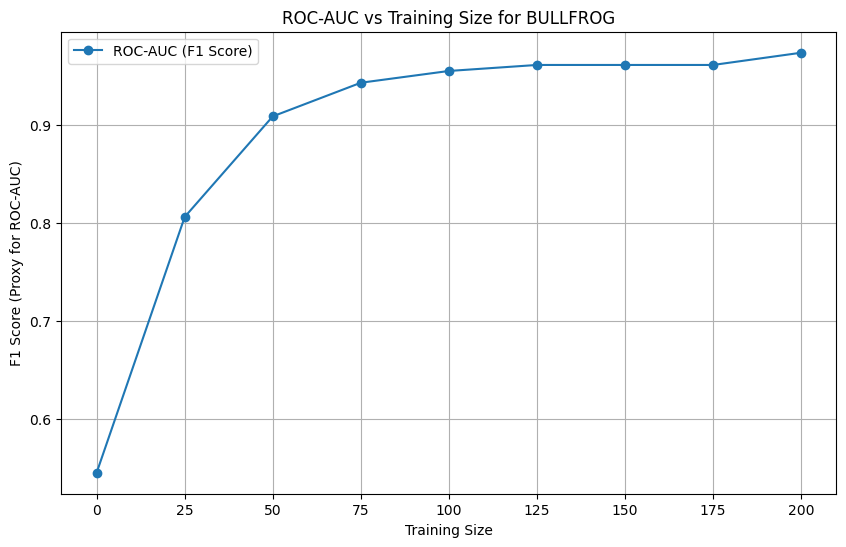

In [1]:
import pandas as pd
import re
import os
import matplotlib.pyplot as plt

def extract_training_size(filename):
    match = re.search(r'_t(\d+)_', filename)
    return int(match.group(1)) if match else None

key_df = pd.read_csv('results-Bullfrog/bullfrog_key.csv')
if 'Begin Time (s)' in key_df.columns:
    key_df = key_df.rename(columns={'Begin Time (s)': 'begin_time_s'})

base_path = 'results-Bullfrog/bullfrog_birdnetv2.4_t{}_e50_b32_l0.001.txt'
results_patterns = [base_path.format(t) for t in range(0, 201, 25)]

merged_table = key_df[['begin_time_s']].drop_duplicates()

for pattern in results_patterns:
    
    if os.path.exists(pattern):
        print(f"Processing file: {pattern}")
        
        training_size = extract_training_size(pattern)
      
        results_df = pd.read_csv(pattern, delimiter='\t')
       
        if 'Begin Time (s)' in results_df.columns:
            results_df = results_df.rename(columns={'Begin Time (s)': 'begin_time_s'})
      
        joined_df = pd.merge(results_df, key_df, on='begin_time_s', how='outer', indicator=True)
        
        joined_df['tp'] = ((joined_df['Annotation'] == 'BULLFROG') & 
                           (joined_df['label'] == 1) & 
                           (joined_df['_merge'] == 'both')).astype(int)
        joined_df['fn'] = ((joined_df['Annotation'] == 'BULLFROG') & 
                           (joined_df['label'] == 1) & 
                           (joined_df['_merge'] == 'right_only')).astype(int)
        joined_df['tn'] = ((joined_df['Annotation'].isna()) & 
                           (joined_df['label'] == 0) & 
                           (joined_df['_merge'] == 'right_only')).astype(int)
        joined_df['fp'] = ((joined_df['Annotation'].isna()) & 
                           (joined_df['label'] == 0) & 
                           (joined_df['_merge'] == 'both')).astype(int)
        
        joined_df[f'tp_t_{training_size}'] = joined_df['tp']
        joined_df[f'fn_t_{training_size}'] = joined_df['fn']
        joined_df[f'fp_t_{training_size}'] = joined_df['fp']
        joined_df[f'tn_t_{training_size}'] = joined_df['tn']
        
        training_columns = [f'tp_t_{training_size}', f'fn_t_{training_size}', f'fp_t_{training_size}', f'tn_t_{training_size}']
        training_data = joined_df[['begin_time_s'] + training_columns].drop_duplicates()
        
        merged_table = pd.merge(merged_table, training_data, on='begin_time_s', how='outer')
    else:
        print(f"File not found: {pattern}")

merged_table.to_csv('output/bullfrog_merged_table.csv', index=False)
print("Saved merged table to 'output/bullfrog_merged_table.csv'")

metrics_summary = []
for training_size in range(0, 201, 25):
    tp = merged_table[f'tp_t_{training_size}'].fillna(0).sum()
    fn = merged_table[f'fn_t_{training_size}'].fillna(0).sum()
    fp = merged_table[f'fp_t_{training_size}'].fillna(0).sum()
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    metrics_summary.append({
        'training_size': training_size, 
        'precision': precision, 
        'recall': recall, 
        'f1_score': f1_score
    })

metrics_df = pd.DataFrame(metrics_summary)
metrics_df.to_csv('output/bullfrog_metrics_summary.csv', index=False)
print("Saved metrics summary to 'output/bullfrog_metrics_summary.csv'")

plt.figure(figsize=(10, 6))
plt.plot(metrics_df['training_size'], metrics_df['f1_score'], marker='o', label='ROC-AUC (F1 Score)')
plt.xlabel('Training Size')
plt.ylabel('F1 Score (Proxy for ROC-AUC)')
plt.title('ROC-AUC vs Training Size for BULLFROG')
plt.legend()
plt.grid(True)

# Save the plot
plot_path = 'output/bullfrog_roc_auc_plot.png'
plt.savefig(plot_path, format='png')
print(f"ROC-AUC plot saved to {plot_path}")

plt.show()
